In [1]:
from cryptory import Cryptory
import quandl
import time
import datetime

In [2]:
from_date="2013-04-28"
to_date=datetime.date.today().strftime("%Y-%m-%d")
my_cryptory = Cryptory(from_date=from_date)
quandl.ApiConfig.api_key = "eJns-j8GmckFnApoFoAE"

In [3]:
# Getting Bitcoin Logo
import sys
from PIL import Image
import io

if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

In [4]:
####################################################################################################################
########
######## Utility Functions for Data PreProcessing
########
####################################################################################################################

import seaborn as sns
from cryptory import Cryptory
import datetime
import matplotlib.pyplot as plt
import urllib2 as urllib
import time
import numpy as np
import pandas as pd
from datetime import timedelta
import numpy as np

"""
    Function to make data from blockchain or other sources consistent with btc exchange data
    If data from APIs has data since 2009 we omit those, if no data exist of a date, the previous date value is used
"""
def drop_initial_rows(api, new_col_name, start_date='2013-04-28'):
    # Read data 
    api_range_format= api
    data = pd.read_csv(urllib.urlopen(api_range_format))
    
    # Check if its the Block Size data
    if 'avg' in api:
        # Format columns
        data = pd.DataFrame(data.values, columns=['date', new_col_name])
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data['date'] = pd.DataFrame(data=data['date'], columns=['date'])

        data['date'] = pd.to_datetime(data['date'])

        # Add dates that do not appear at all, because their blocksize was same as the day before
        data = data.set_index('date').resample('D').ffill()

        # Reset index
        data.index.name='date'
        data = data.reset_index()
        data = data

        # Drop values before 2013, to be consistent with BTC Exchange dataset
        data = data.drop(data[data['date'] < '2013-04-28'].index)
        data = data.reset_index(drop=True)
        return data
        
    else:
        # Get the average block size from blockchain.info; max size ==> 1 MB (by design)
        df = data
        df = pd.DataFrame(df.values, columns=['date', new_col_name])
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df['date'] = pd.DataFrame(data=df['date'], columns=['date'])
        df['date']=df
        df['date'] = pd.to_datetime(df['date'])
        # Remove rows corresponding to dates before 2013-05-02
        df = df.set_index('date').resample('D').ffill()
        df.index.name='date'
        df.index.names = ['date']
        data = df.reset_index()
        df = data
        df[df['date'] < start_date]

        df = df.drop(df[df['date'] < start_date].index)
        df = df.reset_index(drop=True)
        return df

In [5]:
def rename_columns(prepend_to_name, df):
    df.columns = [df.columns[0]]+ \
                [str(prepend_to_name)+i for i in df.columns[1:]]

In [6]:
####################################################################################################################
########
######## Extraction of Blockchain Data
########
####################################################################################################################

# Get the average block size from blockchain.info; max size ==> 1 MB (by design)
block_size_api = "https://blockchain.info/charts/avg-block-size?timespan=all&format=csv" 
avg_block_size = drop_initial_rows(block_size_api, 'avg_block_size')

# Get transactions Daily
txs_api = "https://api.blockchain.info/charts/n-transactions?timespan=all&format=csv" 
txs_data = drop_initial_rows(txs_api, 'transactions')

## Data From Blockchain.info through Quandl API: https://www.quandl.com/data/BCHAIN-Blockchain

# Bitcoin Mining Difficulty
bchain_diff_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/DIFF.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_diff_data = drop_initial_rows(bchain_diff_api, 'difficulty')

# Bitcoin api.blockchain Size
bchain_blchs_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/BLCHS.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_blchs_data = drop_initial_rows(bchain_blchs_api, 'bchain_size')

# Rvenue of Bitcoin Miners
bchain_mirev_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/MIREV.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_mirev_data = drop_initial_rows(bchain_mirev_api, "mining_revenue")

# Bitcoin Hashhttp://localhost:8888/notebooks/Data%20Gathering.ipynb# Rate
bchain_hash_rate_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/CPTRA.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_hash_rate_data = drop_initial_rows(bchain_hash_rate_api, "hash_rate")
                       
# Bitcoin Cost Per Transaction
bchain_cpt_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/NADDU.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_cpt_data = drop_initial_rows(bchain_cpt_api, "cost_per_transaction")   

blockchain_data = avg_block_size.merge(txs_data, on='date', how='inner'). \
            merge(bchain_diff_data,on='date' ,how='inner'). \
            merge(bchain_blchs_data, on='date', how='inner'). \
            merge(bchain_mirev_data, on='date', how='inner'). \
            merge(bchain_hash_rate_data, on='date', how='inner'). \
            merge(bchain_cpt_data, on='date', how='inner')


In [7]:
# Gist of it
blockchain_data.head()

,date,avg_block_size,transactions,difficulty,bchain_size,mining_revenue,hash_rate,cost_per_transaction
0,2013-04-28,0.126539,40986,8.9743e+06,6820,572110,13.9587,107554
1,2013-04-29,0.126539,40986,8.9743e+06,6844,645240,12.9025,73687
2,2013-04-30,0.185539,48795,1.00763e+07,6870,525693,10.7735,60887
3,2013-05-01,0.185539,48795,1.00763e+07,6892,442507,8.77347,61672
4,2013-05-02,0.189949,57278,1.00763e+07,6918,383775,6.70022,67744


In [8]:
####################################################################################################################
######## 
######## Extraction of Macroeconomic Data
########
####################################################################################################################

# S&P 500
s_and_p_stock = my_cryptory.get_stock_prices(market="%5EGSPC")
s_and_p_stock = s_and_p_stock.loc[:,['date', 'close']]
# Rename close column
s_and_p_stock = s_and_p_stock.rename(columns={'close': 'sp_close'})


# Dow and Jones
dow_jones_stock = my_cryptory.get_stock_prices(market="%5EDJI")
dow_jones_stock = dow_jones_stock.loc[:,['date', 'close']]
dow_jones_stock = dow_jones_stock.rename(columns={'close': 'dj_close'})


# Nasdaq
nasdaq_stock = my_cryptory.get_stock_prices(market="%5EIXIC")
nasdaq_stock = nasdaq_stock.loc[:,['date', 'close']]
nasdaq_stock = nasdaq_stock.rename(columns={'close': 'nasdaq_close'})

# Vix
vix_stock = my_cryptory.get_stock_prices(market="%5EVIX")
vix_stock = vix_stock.loc[:,['date', 'close']]
vix_stock = vix_stock.rename(columns={'close': 'vix_close'})

# Commodity Prices
metals_prices = my_cryptory.get_metal_prices()
metals_prices = metals_prices[['date', 'gold_am', 'silver']]

# Oil Price
oil_price = my_cryptory.get_oil_prices()

macro_econ_data = s_and_p_stock.merge(dow_jones_stock,on='date', how='inner') \
                .merge(nasdaq_stock,on='date', how='inner') \
                .merge(vix_stock, on='date', how='inner') \
                .merge(metals_prices,on='date', how='inner') \
                .merge(oil_price, on='date', how='inner')


In [9]:
# Gist of it
macro_econ_data.head() 

,date,sp_close,dj_close,nasdaq_close,vix_close,gold_am,silver,oil_price
0,2018-09-18,2909.830078,26300.710938,7974.403320,12.82,1196.8,14.170,67.55
1,2018-09-17,2888.800049,26062.119141,7895.790039,13.68,1196.8,14.170,67.55
2,2018-09-16,2904.979980,26154.669922,8010.040039,12.07,1206.2,14.215,67.55
3,2018-09-15,2904.979980,26154.669922,8010.040039,12.07,1206.2,14.215,67.55
4,2018-09-14,2904.979980,26154.669922,8010.040039,12.07,1206.2,14.215,67.55


In [10]:
####################################################################################################################
########
######## Extract Exchange Data
########
####################################################################################################################

# Daily data from coinmarketcap
coinmarket_btc_market_info = my_cryptory.extract_coinmarketcap("bitcoin")

[]

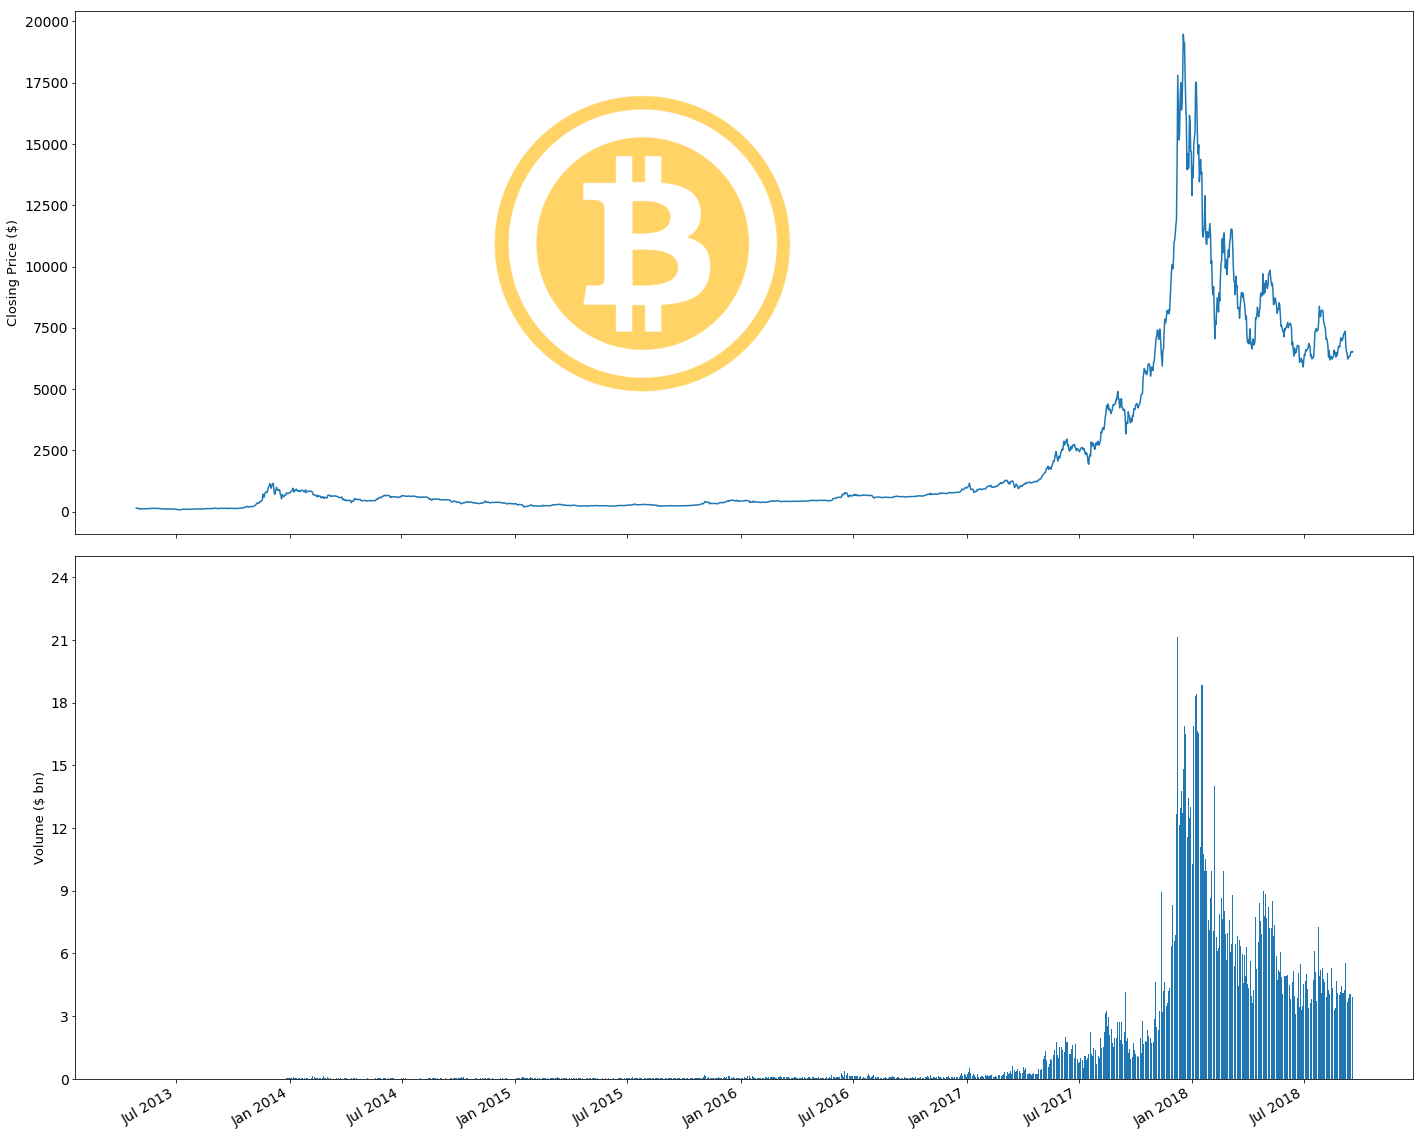

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 14
# rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 5]} )
fig.autofmt_xdate()

ax1.set_ylabel('Closing Price ($)',fontsize=13)
ax2.set_ylabel('Volume ($ bn)',fontsize=13)
ax2.set_yticks([int('%d000000000'%i) for i in range(0, 25, 3)])
ax2.set_yticklabels(range(0, 25, 3))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(coinmarket_btc_market_info['date'].astype(datetime.datetime),coinmarket_btc_market_info['open'])
ax2.bar(coinmarket_btc_market_info['date'].astype(datetime.datetime).values, coinmarket_btc_market_info['volume'].values)
fig.tight_layout()

# print(bitcoin_market_info['bt_Volume'].values.max())
fig.figimage(bitcoin_im, 320, 650, zorder=3, alpha=.6)
plt.plot(subplots=True)
# plt.show()

In [37]:
btc_market_info = my_cryptory.extract_coinmarketcap('bitcoin')
btc_market_info = coinmarket_btc_market_info.assign(Date=pd.to_datetime(btc_market_info['date']))
pd.DataFrame(btc_market_info).fillna(btc_market_info.mean())
# Housekeeping
btc_market_info['volume'] = btc_market_info['volume'].astype('int64')
btc_market_info.columns = btc_market_info.columns.str.replace("*", "") 
btc_market_info = btc_market_info.assign(Date=pd.to_datetime(btc_market_info['date'])) 
rename_columns('bt_', btc_market_info)

# Calculate new columns
for coins in ['bt_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'close']-x[coins+'open'])/x[coins+'open']}
    btc_market_info = btc_market_info.assign(**kwargs)

for coins in ['bt_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'high']- x[coins+'close'])/(x[coins+'high']-x[coins+'low'])-1,
            coins+'volatility': lambda x: (x[coins+'high']- x[coins+'low'])/(x[coins+'open'])}
    btc_market_info = btc_market_info.assign(**kwargs)

Text(0.5,1,'Bitcoin Daily Price Changes')

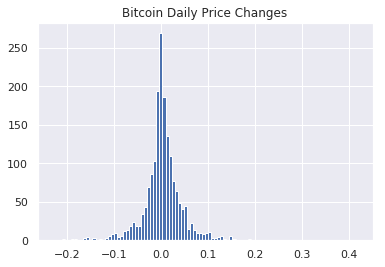

In [40]:
fig, ax1 = plt.subplots()
ax1.hist(btc_market_info[btc_market_info['date']< split_date]['bt_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')

In [41]:

# USD - EUR
eur_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")
eur_usd_exchange_rate = eur_usd_exchange_rate.rename(columns={'exch_rate': 'eur_exch_rate'})

# USD - JPY
jpy_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="JPY")
jpy_usd_exchange_rate = jpy_usd_exchange_rate.rename(columns={'exch_rate': 'jpy_exch_rate'})

# USD - Yuan
cny_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="CNY")
cny_usd_exchange_rate = cny_usd_exchange_rate.rename(columns={'exch_rate': 'cny_exch_rate'})


exchange_data = btc_market_info.merge(eur_usd_exchange_rate, on='date', how='inner'). \
            merge(jpy_usd_exchange_rate,on='date' ,how='inner'). \
            merge(cny_usd_exchange_rate, on='date', how='inner')

# Get Rid of data that was included in new columns
exchange_data = exchange_data[['date','eur_exch_rate','jpy_exch_rate','cny_exch_rate']+[coin+metric for coin in ['bt_'] 
                                   for metric in ['close','volume','close_off_high','volatility']]]

In [42]:
exchange_data.head()

,date,eur_exch_rate,jpy_exch_rate,cny_exch_rate,bt_close,bt_volume,bt_close_off_high,bt_volatility
0,2018-09-17,1.1671,0.009147,0.157811,6281.20,3910780000,0.832467,0.043397
1,2018-09-16,1.1689,0.009147,0.157811,6517.18,3273730000,-0.355337,0.012886
2,2018-09-15,1.1689,0.009147,0.157811,6543.20,3216300000,-0.456652,0.010473
3,2018-09-14,1.1689,0.009147,0.157811,6512.71,4076220000,0.191882,0.021477
4,2018-09-13,1.1620,0.009147,0.157811,6517.31,4210910000,-0.800188,0.028512


In [43]:
####################################################################################################################
########
######## Extract Sentiment Data
########
####################################################################################################################
btc_google_trends = my_cryptory.get_google_trends(kw_list=['bitcoin'])
rename_columns('google_trends_', btc_google_trends)

btc_google_trends.head()
# # Leave our reddit for now
# btc_reddit_subscribers = my_cryptory.extract_reddit_metrics(subreddit="bitcoin", 
#                                          metric="total-subscribers")
# rename_columns('reddit_', btc_reddit_subscribers)

,date,google_trends_bitcoin
0,2018-09-16,4.624389
1,2018-09-15,5.202437
2,2018-09-14,5.780486
3,2018-09-13,6.358535
4,2018-09-12,6.358535


In [44]:
####################################################################################################################
########
######## Merge All Data (Blockchain, Macroeconomic, Exchange, Sentiment) into a Final Data Set
########
####################################################################################################################

btc_final = exchange_data.merge(btc_google_trends, on='date', how='inner'). \
            merge(blockchain_data,on='date' ,how='inner'). \
            merge(macro_econ_data, on='date', how='inner')

arr = btc_final.columns.values

In [45]:
# need to reverse the data frame so that subsequent rows represent later timepoints
btc_final = btc_final.sort_values(by='date')
btc_final.to_csv('btc_data_reconciliation.csv')

In [46]:
# NORMALIZE USING MIN-MAX METHOD INSTEAD OF STANDARDIZATION
from sklearn.preprocessing import minmax_scale
import numpy as np
from sklearn.preprocessing import Imputer

mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

btc_without_date = btc_final.loc[:, btc_final.columns != 'date']

# Train the imputor on the df dataset
mean_imputer = mean_imputer.fit(btc_without_date)

# Apply the imputer to the df dataset
imputed_df = mean_imputer.transform(btc_without_date)

# Get back columns
imputed_df = pd.DataFrame(imputed_df, columns = btc_without_date.columns)

# # From numpy array to numpy list
# all_columns_list = btc_final.columns.values.tolist()

imputed_df[['eur_exch_rate', 'jpy_exch_rate', 'cny_exch_rate', 'bt_close', 'bt_volume', 'bt_close_off_high', 'bt_volatility', 'google_trends_bitcoin', 'avg_block_size', 'transactions', 'difficulty', 'bchain_size', 'mining_revenue', 'hash_rate', 'cost_per_transaction', 'sp_close', 'dj_close', 'nasdaq_close', 'vix_close', 'gold_am', 'silver', 'oil_price']] = \
        minmax_scale(imputed_df[['eur_exch_rate', 'jpy_exch_rate', 'cny_exch_rate', 'bt_close', 'bt_volume', 'bt_close_off_high', 'bt_volatility', 'google_trends_bitcoin', 'avg_block_size', 'transactions', 'difficulty', 'bchain_size', 'mining_revenue', 'hash_rate', 'cost_per_transaction', 'sp_close', 'dj_close', 'nasdaq_close', 'vix_close', 'gold_am', 'silver', 'oil_price']])

# Re add date column
imputed_df['date'] = btc_final['date']

# Order by date
imputed_df["date"] = imputed_df["date"].values[::-1]

btc_final=imputed_df

In [47]:
# Get rid of rows where volume is 0
btc_final = btc_final[btc_final['bt_volume']!=0]
# Reindex, starting from 0 
btc_final.index = range(len(btc_final))

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

/home/kejsi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


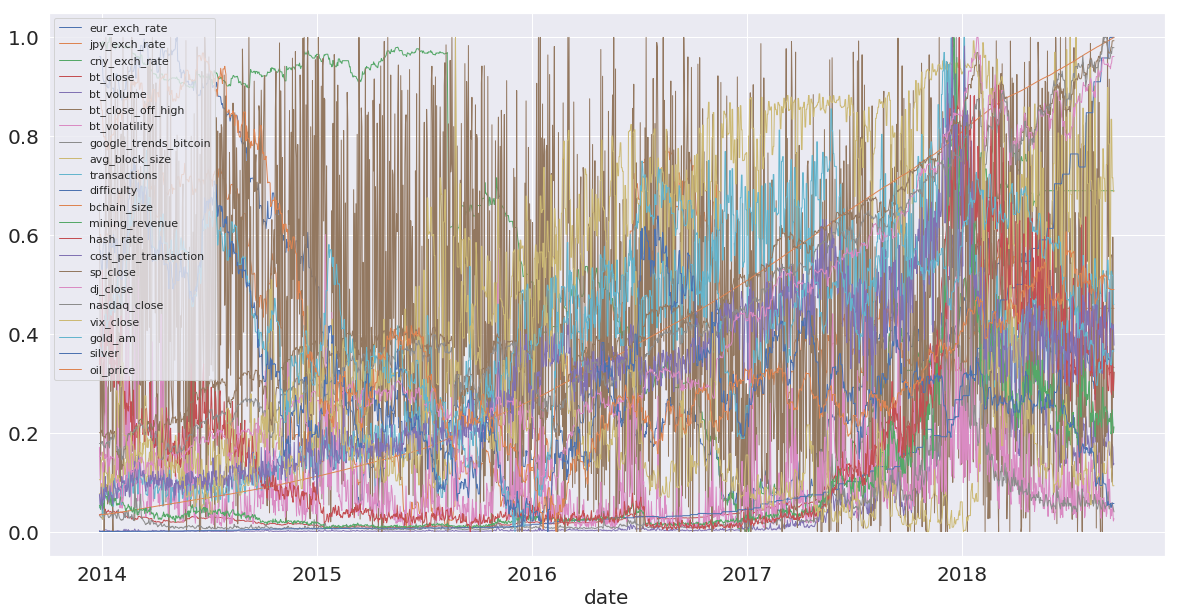

In [49]:
test = btc_final.copy()
test.date_index = pd.to_datetime(test['date'])
test.set_index('date', inplace=True)
test.plot(figsize=(20,10), linewidth=1, fontsize=20)
plt.xlabel('date', fontsize=20);

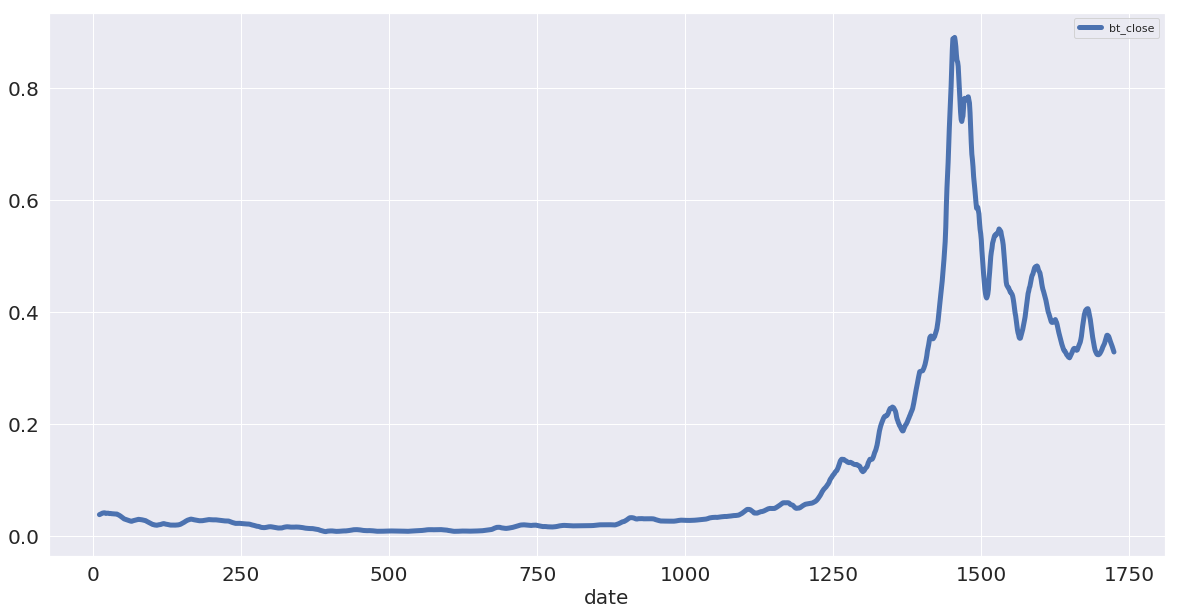

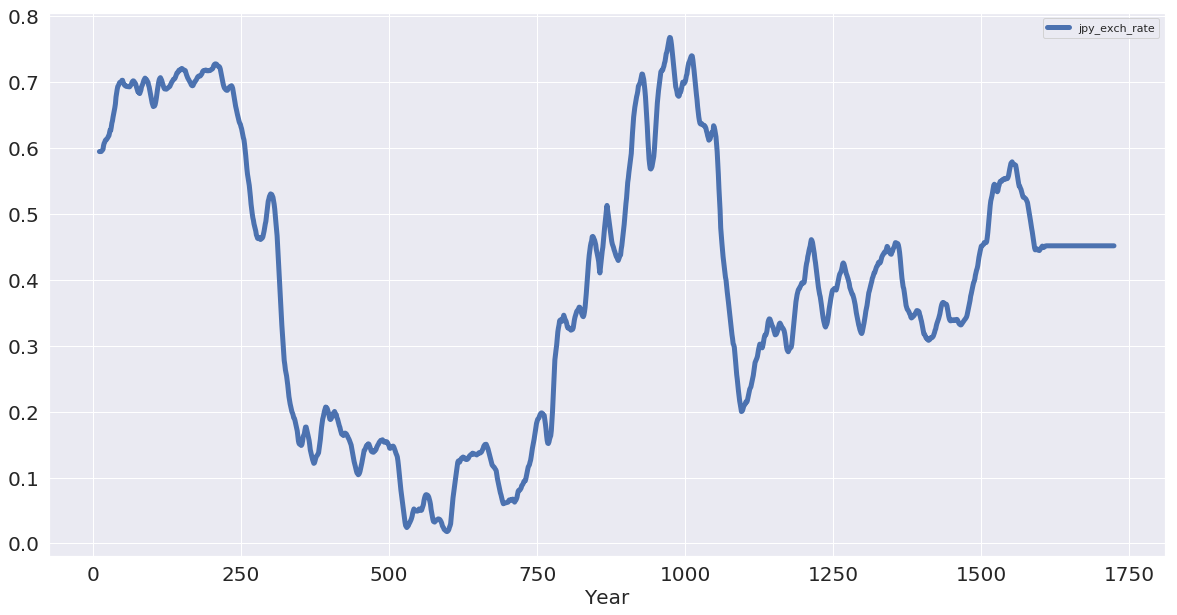

In [51]:
# Trying to get out of the graph up, we check for seasonality
btc_close_price = btc_final[['bt_close']]
btc_close_price.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('date', fontsize=20);

yen = btc_final[['jpy_exch_rate']]
yen.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

'\n    Removing the trends seems almost atrocious; The bubbles are very apparent\n'

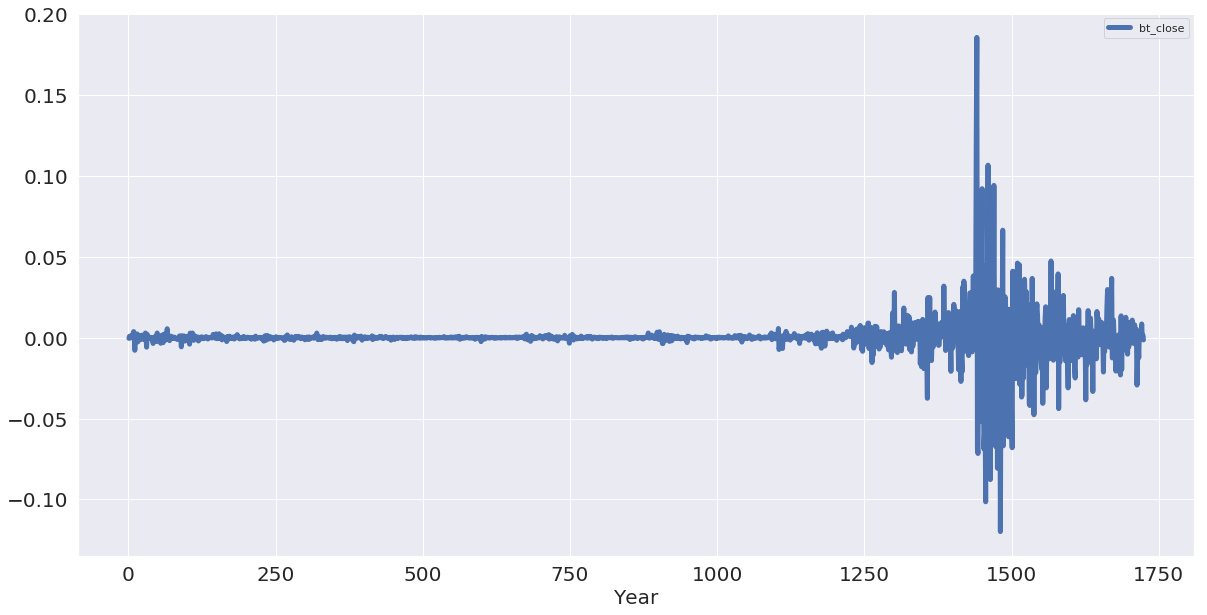

In [53]:
# First Order Differencing
btc_close_price.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);
"""
    Removing the trends seems almost atrocious; The bubbles are very apparent
"""

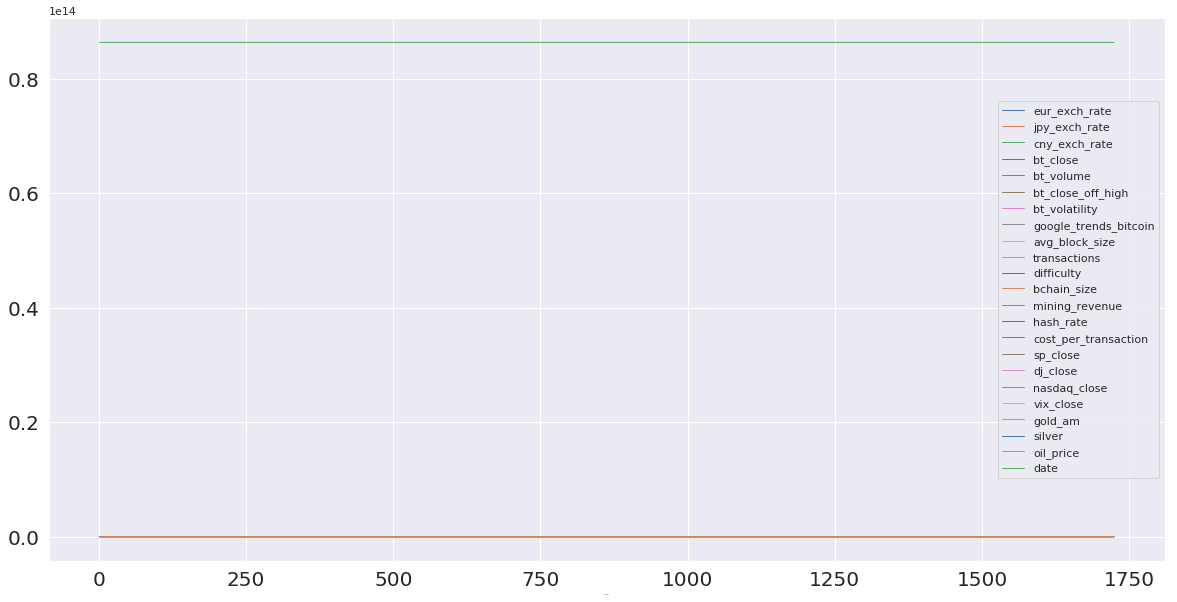

In [56]:
btc_final.diff().plot(figsize=(20,10), linewidth=1, fontsize=20)
plt.xlabel('Year', fontsize=2);

/home/kejsi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


TypeError: long() argument must be a string or a number, not 'Timestamp'

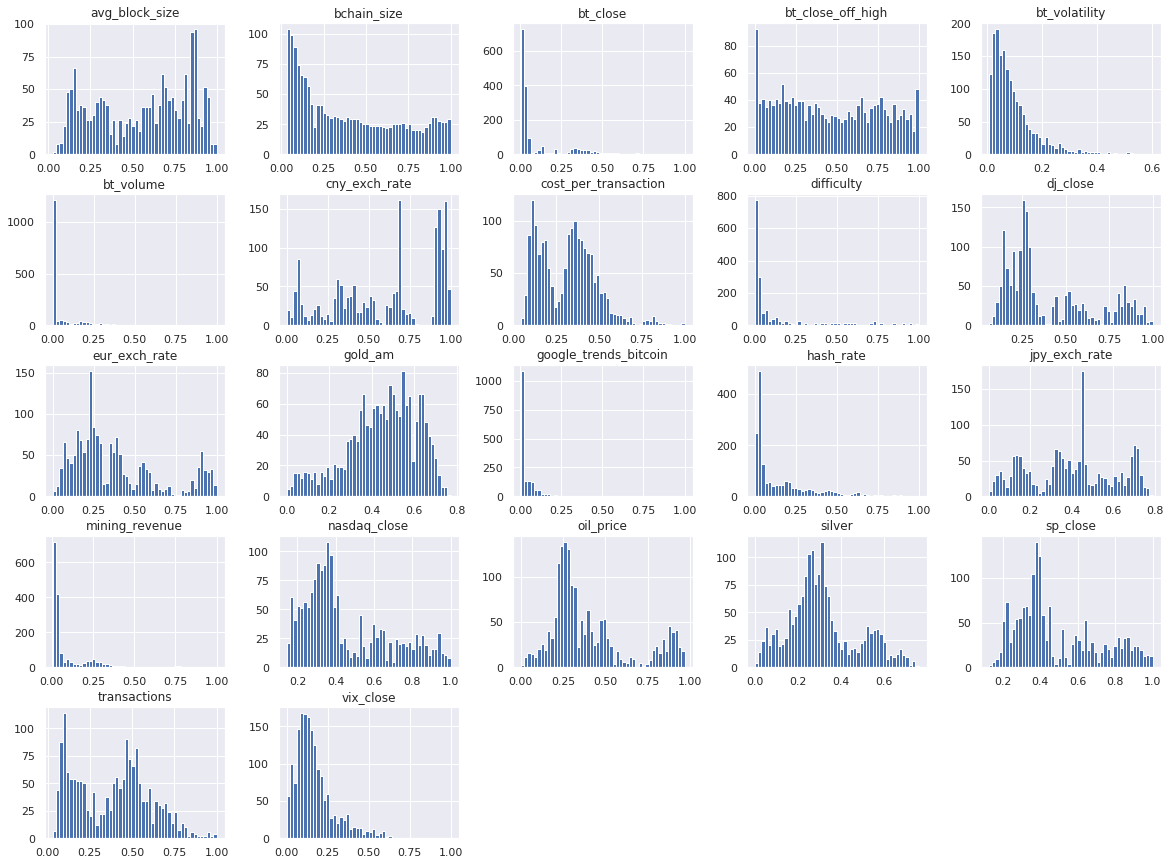

In [75]:
btc_final.hist(bins=50, figsize=(20,15))
# print(all_coins_df)
plt.show()

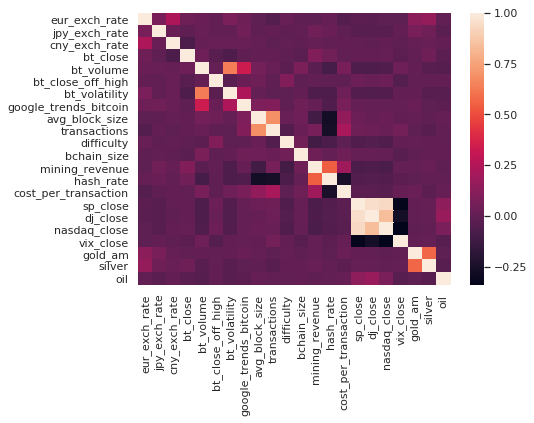

,eur_exch_rate,jpy_exch_rate,cny_exch_rate,bt_close,bt_volume,bt_close_off_high,bt_volatility,google_trends_bitcoin,avg_block_size,transactions,difficulty,bchain_size,mining_revenue,hash_rate,cost_per_transaction,sp_close,dj_close,nasdaq_close,vix_close,gold_am,silver,oil_price
eur_exch_rate,1,0.072,0.24,0.034,0.026,0.0052,0.075,0.035,-0.011,-0.046,0.018,-0.008,-0.012,0.015,-0.046,-0.015,-0.026,-0.014,-0.014,0.13,0.16,-0.0012
jpy_exch_rate,0.072,1,0.025,-0.0074,0.019,0.00055,-0.0034,0.05,-0.0057,0.0047,-0.0049,-0.0015,0.052,0.025,-0.0051,-0.033,-0.026,-0.028,0.0046,0.07,0.037,-0.021
cny_exch_rate,0.24,0.025,1,-0.072,0.016,0.02,0.017,0.017,0.0083,-0.012,-0.004,-0.0047,0.012,-0.0044,0.0056,-0.0037,-0.0054,0.0021,-0.0047,0.014,0.017,0.0023
bt_close,0.034,-0.0074,-0.072,1,0.041,-0.032,-0.065,-0.0071,0.0052,0.0014,-0.0076,-0.025,0.096,0.047,-0.0029,0.0037,0.0012,0.012,-0.02,-0.00026,0.037,-0.025
bt_volume,0.026,0.019,0.016,0.041,1,0.0083,0.64,0.33,0.053,0.021,-0.019,0.081,-0.023,-0.091,0.071,-0.063,-0.064,-0.06,0.038,0.0018,-0.031,-0.037
bt_close_off_high,0.0052,0.00055,0.02,-0.032,0.0083,1,-0.024,0.023,0.032,-0.0063,0.099,-0.0075,-0.0032,-0.0063,-0.0069,0.032,0.021,0.03,-0.046,-0.00078,2.1e-05,0.0054
bt_volatility,0.075,-0.0034,0.017,-0.065,0.64,-0.024,1,0.24,0.0077,-0.014,-0.013,0.0017,-0.064,-0.064,0.038,-0.049,-0.052,-0.051,0.0038,0.0013,-0.035,-0.026
google_trends_bitcoin,0.035,0.05,0.017,-0.0071,0.33,0.023,0.24,1,0.089,0.099,-0.008,0.035,0.012,-0.06,0.07,0.011,0.0076,0.0095,0.0075,0.024,-0.014,-0.019
avg_block_size,-0.011,-0.0057,0.0083,0.0052,0.053,0.032,0.0077,0.089,1,0.69,0.016,0.038,-0.1,-0.27,0.15,0.027,0.012,0.025,0.0054,0.0069,-0.0055,0.011
transactions,-0.046,0.0047,-0.012,0.0014,0.021,-0.0063,-0.014,0.099,0.69,1,-0.048,0.025,0.065,-0.26,0.22,0.032,0.027,0.018,0.054,-0.012,-0.029,-0.0044


In [76]:
# Pearson correlation on all attributes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# date column not need for upcoming calculations
all_features_df = btc_final.drop('date', axis=1)
# Percentage change => 
# first calculate: Increase = y_t - y_(t-1) then calculate: %Increace = (Increase-y_(t-1))*100
"""
    %Increase is used both to track the prices of individual securities and 
    of large market indexes, as well as comparing the values of different currencies.  
    Balance sheets with comparative financial statements will generally include the 
    prices of specific assets at different points in time along with the percentage 
    changes over the accompanying periods of time.  
"""
# Compute pairwise correlation of columns, excluding NA/null values
corr = all_features_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            annot_kws={"size": 16})
plt.show()


# Table view for readibility
# cmap=sns.diverging_palette(5, 250, as_cmap=True)
cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

In [78]:
split_date = '2018-03-01' # Therefore, the test dataset has values from 2018-01-03 to 2018-09-13

# we don't need the date columns anymore
training_set, test_set = btc_final[btc_final['date']<split_date], btc_final[btc_final['date']>=split_date]
training_set = training_set.drop('date', 1)
test_set = test_set.drop('date', 1)

In [79]:
window_len = 10
norm_cols = ['bt_close','bt_volume']

In [80]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_close'][window_len:].values/training_set['bt_close'][:-window_len].values)-1

In [81]:
print(LSTM_training_outputs)

[ 0.32734309  0.11248104  0.14434986 ...  0.01306383 -0.03504985
 -0.01468039]


In [82]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_close'][window_len:].values/test_set['bt_close'][:-window_len].values)-1
print(LSTM_test_outputs)

[-1.26107160e-01 -1.70746517e-01 -2.00927743e-01 -2.83357378e-01
 -2.84439546e-01 -2.27937902e-01 -2.06998183e-01 -1.25590517e-01
 -7.62639819e-02  5.39580816e-03 -6.82793211e-02 -5.21687832e-02
 -3.45403784e-02  4.85662169e-02  2.36770917e-02 -1.55926539e-02
 -1.06823640e-02 -3.30094111e-02 -1.71094646e-01 -2.28710102e-01
 -2.20718103e-01 -2.17578672e-01 -2.03811290e-01 -1.40936476e-01
 -1.94834675e-01 -1.71715410e-01 -1.54124934e-01 -1.32308317e-01
 -2.00330550e-02 -1.75591351e-02 -2.00967401e-02  1.83137047e-02
  1.14812191e-01  5.95383124e-02  1.66887484e-01  2.25067625e-01
  2.16561179e-01  1.44826719e-01  1.63894357e-01  2.27321964e-01
  2.97217251e-01  2.79317496e-01  1.16766528e-01  1.32215399e-01
  2.16127944e-01  6.25408562e-02  1.53041711e-01  1.38499756e-01
  1.46394251e-01  1.36735523e-01  4.49700367e-02  2.53116804e-02
  4.96288655e-02  9.17330986e-02  3.38558137e-04  1.15343995e-01
  4.05173948e-02  4.32757534e-02 -1.22477788e-02 -1.00420826e-02
 -2.14356114e-02 -7.48592

In [83]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)
# print(btc_final)

      eur_exch_rate  jpy_exch_rate  cny_exch_rate  bt_close  bt_volume  \
0          0.961270       0.601035       0.984144  0.034312   0.001966   
1          0.961270       0.601035       0.984144  0.033939   0.001363   
2          0.961270       0.601035       0.984144  0.034825   0.000797   
3          0.952632       0.587041       0.987575  0.035396   0.000869   
4          0.952632       0.587041       0.987575  0.035286   0.000877   
5          0.952632       0.587041       0.987575  0.036182   0.000943   
6          0.917804       0.587041       0.992064  0.037777   0.001614   
7          0.911117       0.587041       0.985595  0.038617   0.001586   
8          0.911117       0.587041       0.985595  0.040717   0.001594   
9          0.911117       0.587041       0.985595  0.044526   0.003058   
10         0.902201       0.608425       0.982958  0.045543   0.003589   
11         0.913067       0.616553       0.985200  0.037757   0.003411   
12         0.899972       0.601035    

In [84]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    
    print(inputs.shape[1])
    print(inputs.shape[2])
    
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


In [ ]:
%matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 100
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_close'][i:i+pred_range].values/
                                  training_set['bt_close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

10
22
Epoch 1/50
 - 17s - loss: 0.2679
Epoch 2/50
 - 18s - loss: 0.2407
Epoch 3/50
 - 12s - loss: 0.2315
Epoch 4/50
 - 15s - loss: 0.2248
Epoch 5/50
 - 14s - loss: 0.2176
Epoch 6/50
 - 16s - loss: 0.2101
Epoch 7/50
 - 16s - loss: 0.2044
Epoch 8/50
 - 8s - loss: 0.1961
Epoch 9/50
 - 10s - loss: 0.1938
Epoch 10/50
 - 19s - loss: 0.1903
Epoch 11/50
 - 11s - loss: 0.1844
Epoch 12/50
 - 10s - loss: 0.1787
Epoch 13/50
 - 9s - loss: 0.1766
Epoch 14/50
 - 7s - loss: 0.1702
Epoch 15/50
 - 16s - loss: 0.1675
Epoch 16/50
 - 11s - loss: 0.1658
Epoch 17/50
 - 9s - loss: 0.1596
Epoch 18/50
 - 7s - loss: 0.1602
Epoch 19/50
 - 7s - loss: 0.1572
Epoch 20/50
 - 8s - loss: 0.1614
Epoch 21/50
 - 10s - loss: 0.1547
Epoch 22/50
 - 10s - loss: 0.1563
Epoch 23/50
 - 12s - loss: 0.1527
Epoch 24/50
 - 11s - loss: 0.1515
Epoch 25/50
 - 10s - loss: 0.1498
Epoch 26/50
 - 7s - loss: 0.1508
Epoch 27/50
 - 6s - loss: 0.1491
Epoch 28/50
 - 6s - loss: 0.1489
Epoch 29/50
 - 7s - loss: 0.1463
Epoch 30/50
 - 7s - loss: 0.

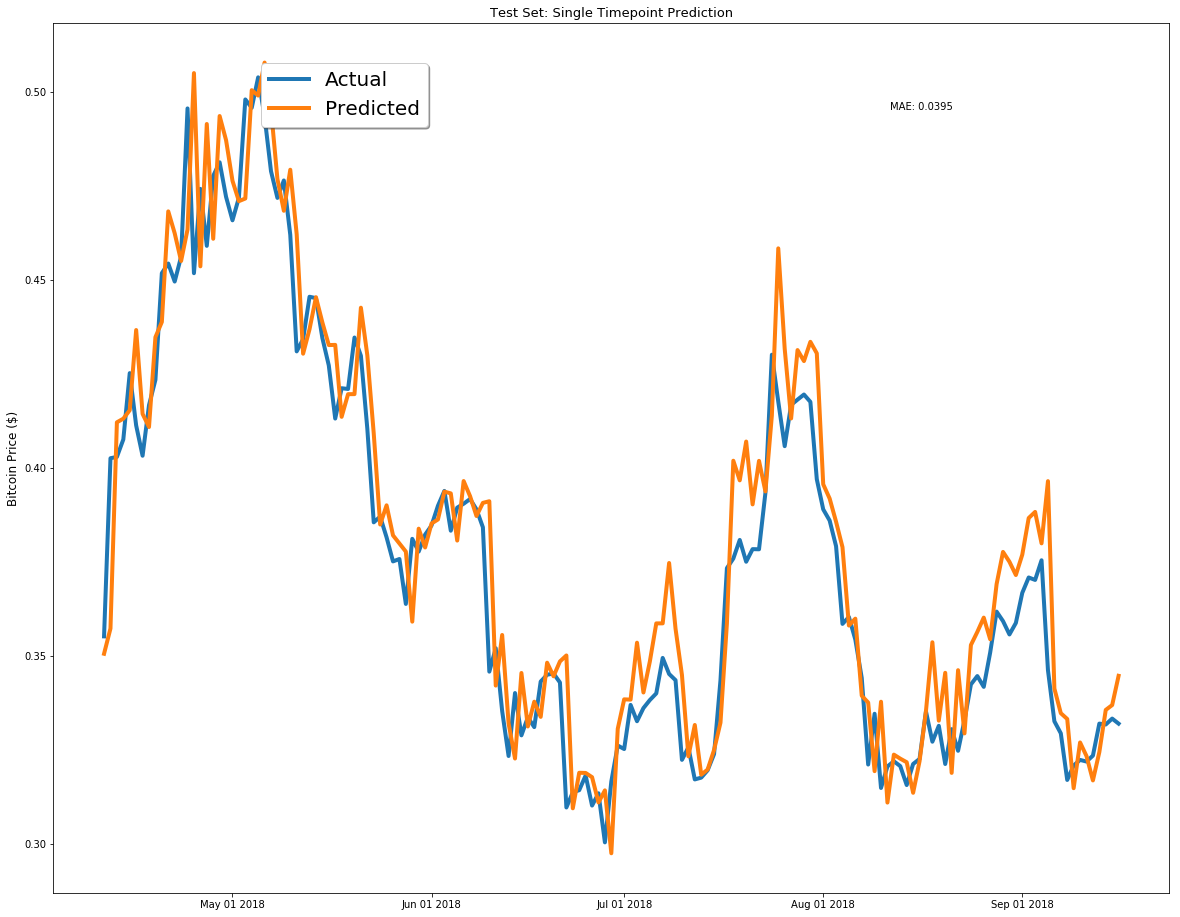

In [29]:
%matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['bt_close'][window_len:], label='Actual')

ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')

ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_close'].values[window_len:])/(test_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()

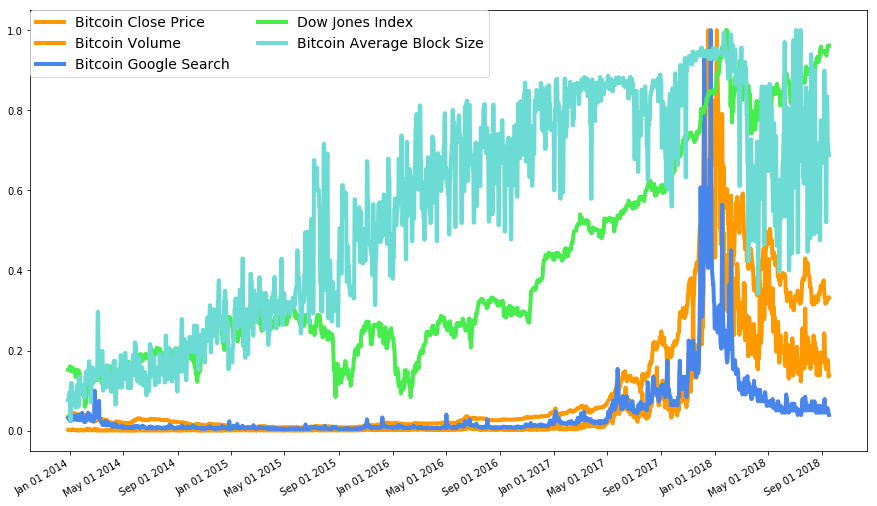

In [32]:
%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(15, 9)) # 1 row 1 col

from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

fig.autofmt_xdate()

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,4) for j in range(2013,2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') 
                     for i in range(1,13,4) for j in range(2013,2019)])

ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bt_close'], label='Bitcoin Close Price', color='#FF9900')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bt_volume'], label='Bitcoin Volume', color='#FF9900')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['google_trends_bitcoin'], label="Bitcoin Google Search", color='#4885ed')
# ax1.plot(btc_final['date'].astype(datetime.datetime),
#              btc_final['reddit_total_subscribers'], label="Bitcoin Reddit Subscribers", color='#ed475e')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['dj_close'], label="Dow Jones Index", color='#47ed4c')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['avg_block_size'], label="Bitcoin Average Block Size", color='#6bdbd3')

ax1.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
plt.show()

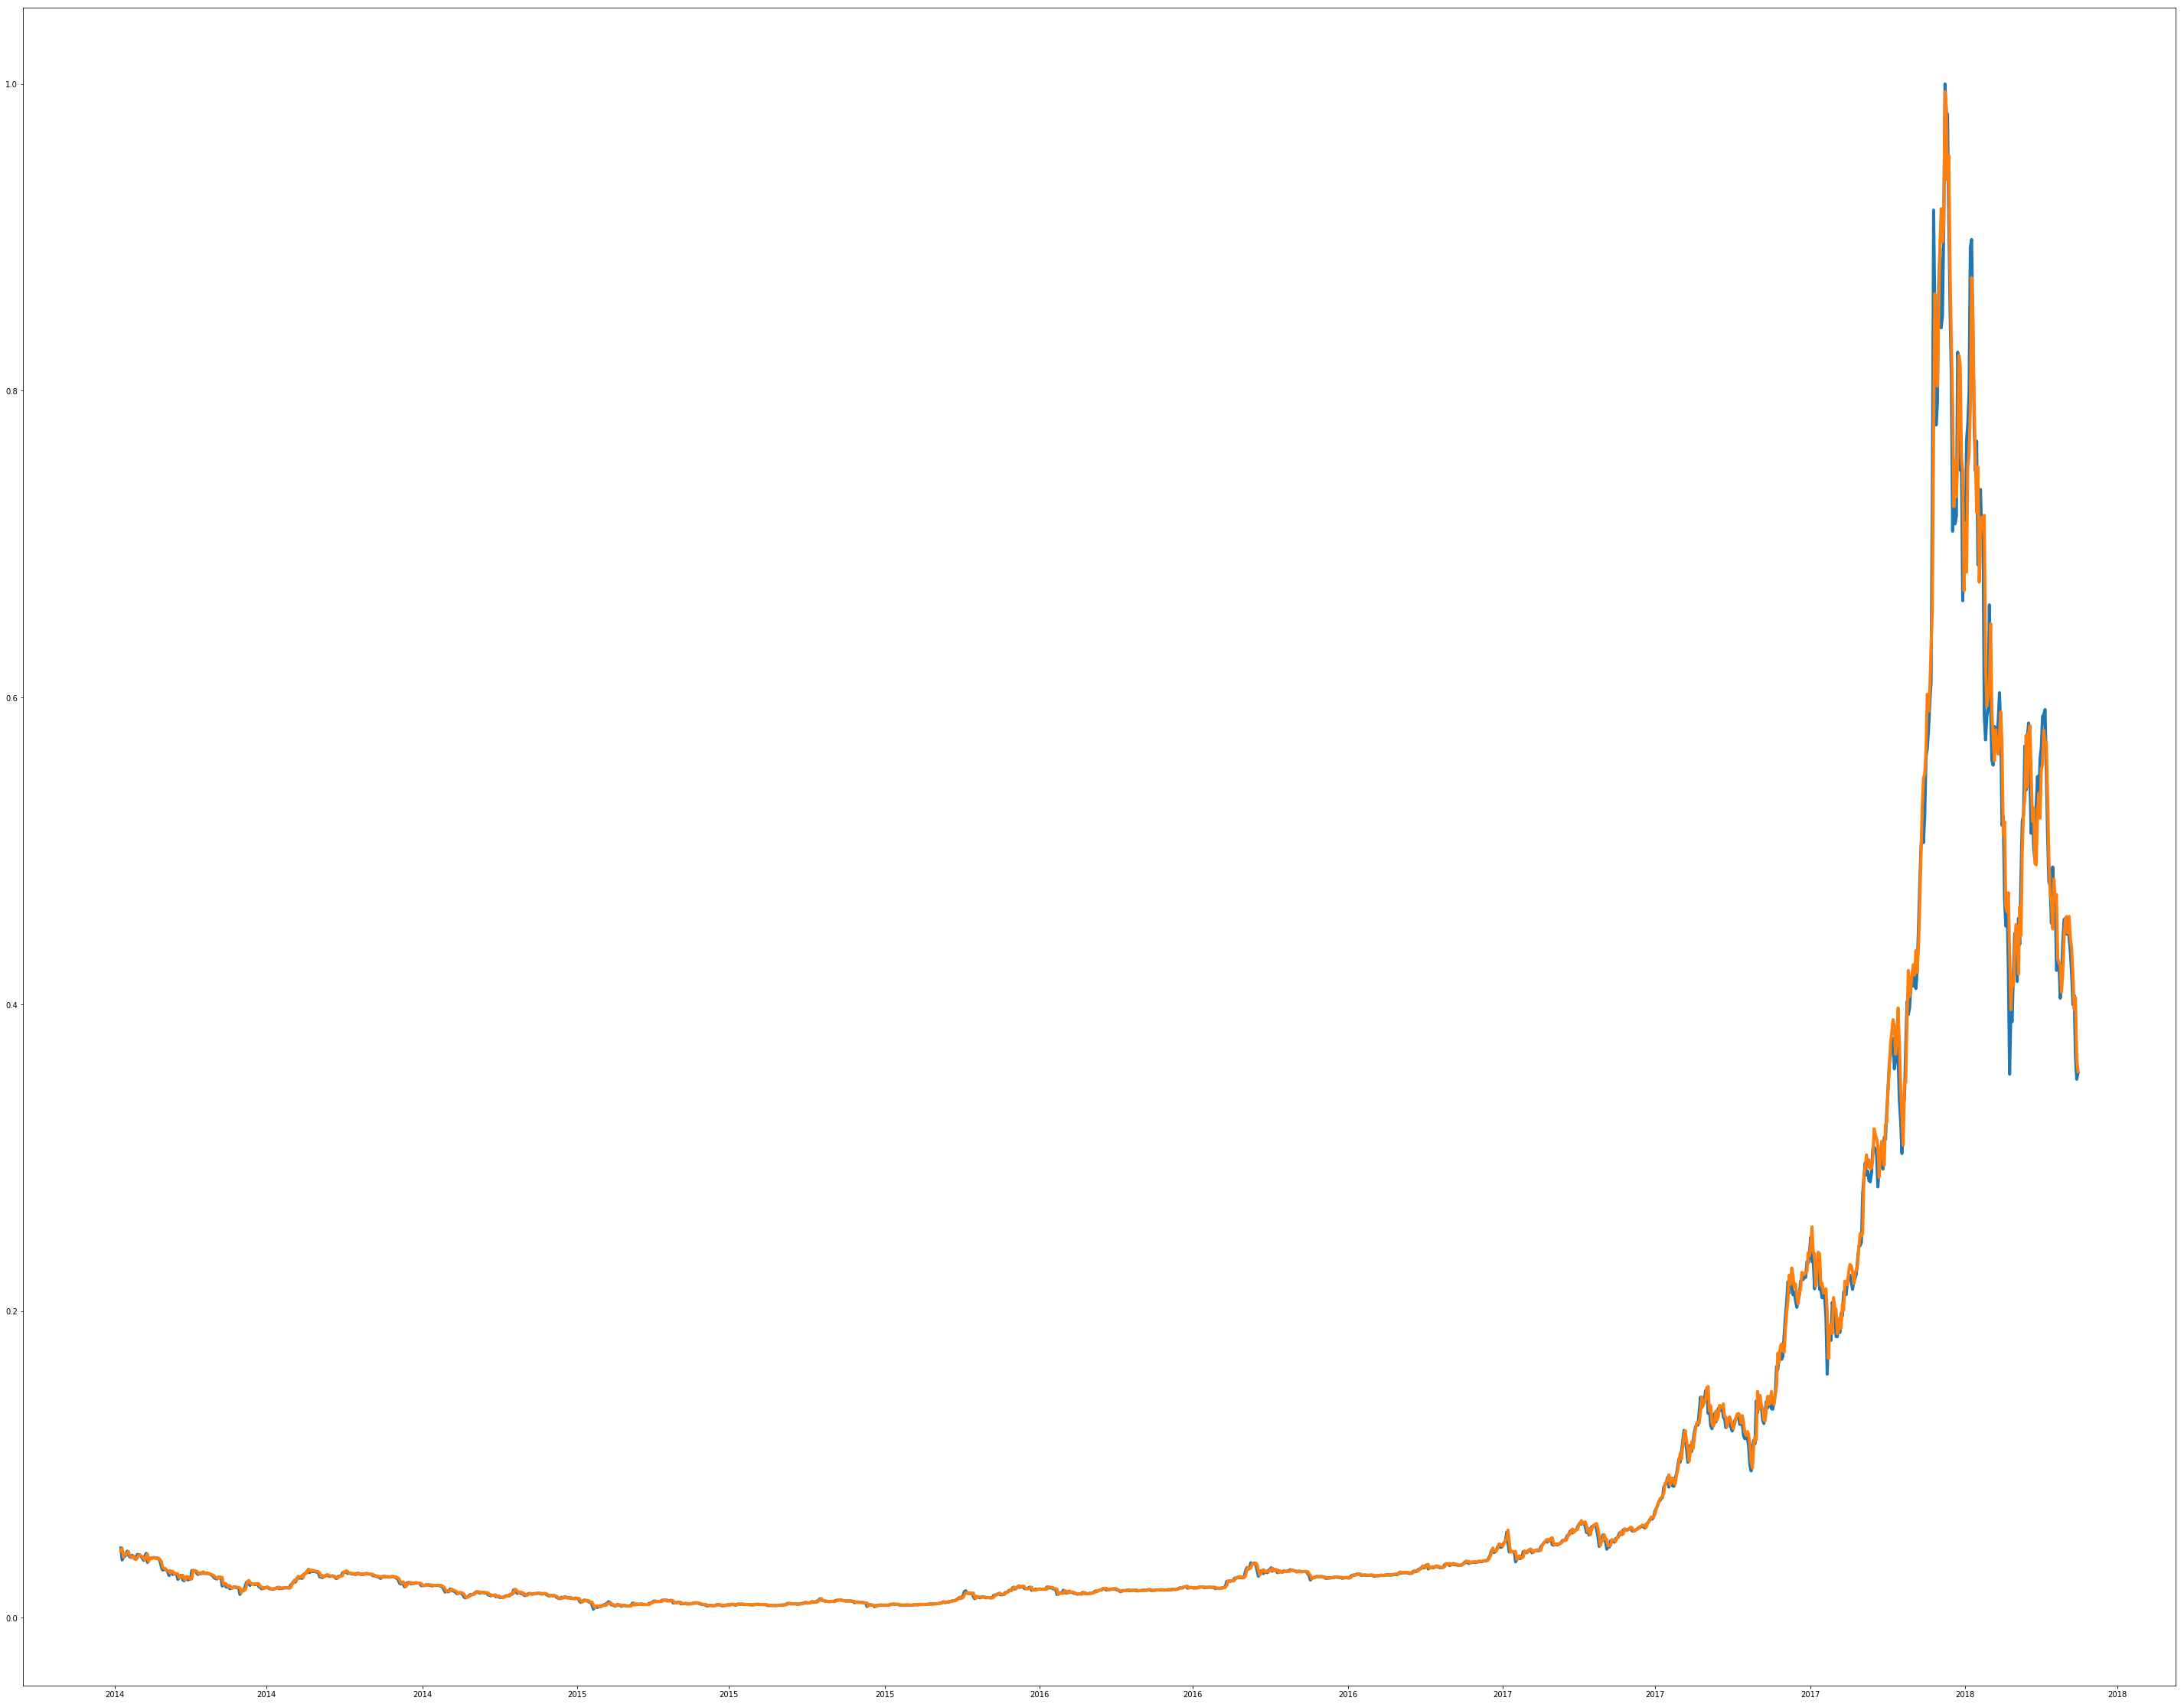

In [33]:
%matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2014,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2014,2019) for j in [1,5,9]])
ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')
ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_close'].values[window_len:])/(training_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
# axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
# axins.set_ylim([920, 1400])
# mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

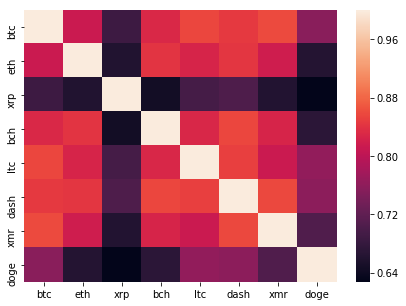

In [37]:
# Pearson correlation on all data sources
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

my_cryptory = Cryptory(from_date="2018-01-01")
all_coins_df = my_cryptory.extract_bitinfocharts("btc")
# coins of interest
bitinfocoins = ["btc", "eth", "xrp", "bch", "ltc", "dash", "xmr", "doge"]
for coin in bitinfocoins[1:]:
    all_coins_df = all_coins_df.merge(my_cryptory.extract_bitinfocharts(coin), on="date", how="left")
# date column not need for upcoming calculations
all_coins_df = all_coins_df.drop('date', axis=1)
# Percentage change => 
# first calculate: Increase = y_t - y_(t-1) then calculate: %Increace = (Increase-y_(t-1))*100
"""
    %Increase is used both to track the prices of individual securities and 
    of large market indexes, as well as comparing the values of different currencies.  
    Balance sheets with comparative financial statements will generally include the 
    prices of specific assets at different points in time along with the percentage 
    changes over the accompanying periods of time.  
"""
# Compute pairwise correlation of columns, excluding NA/null values
corr = all_coins_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            annot_kws={"size": 16})
plt.show()

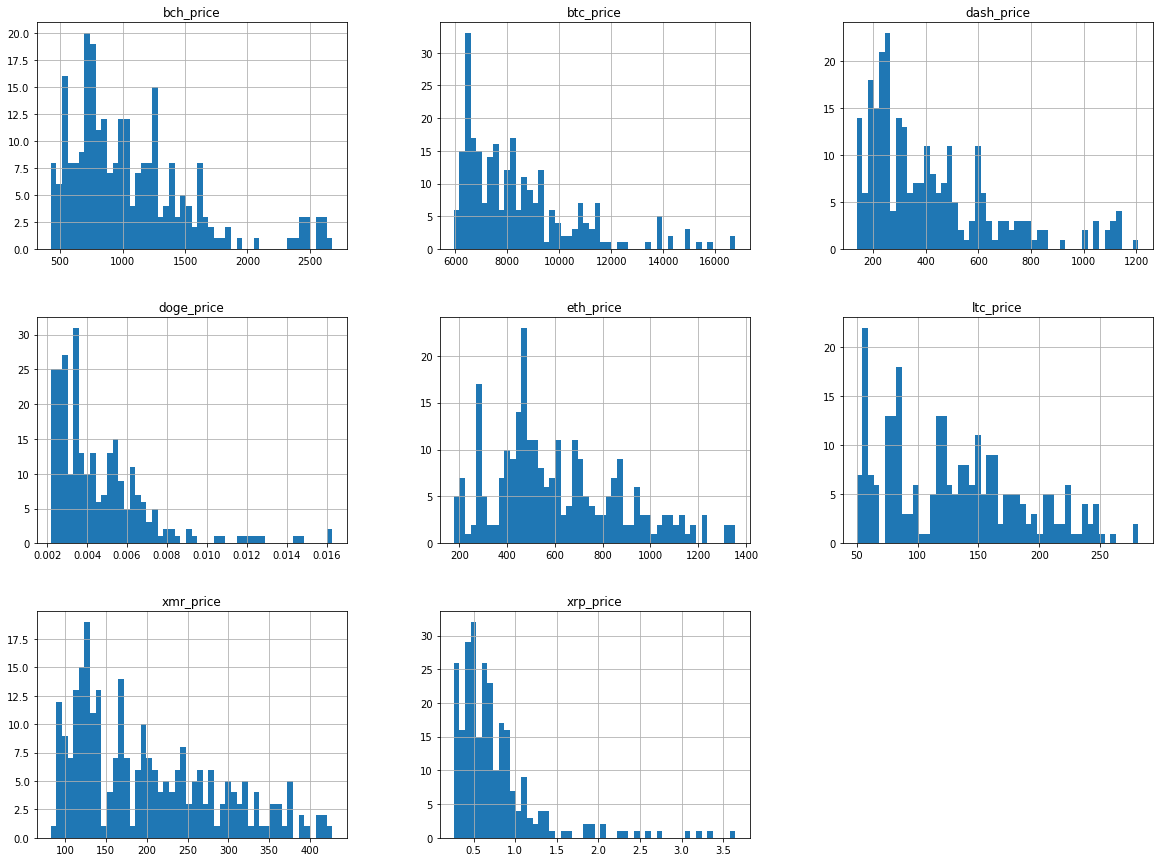

In [38]:
import matplotlib.pyplot as plt
all_coins_df.hist(bins=50, figsize=(20,15))
# print(all_coins_df)
plt.show()

In [ ]:
# Visualize all gathered data
%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(15, 9)) # 1 row 1 col

fig.autofmt_xdate()

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,4) for j in range(2013,2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') 
                     for i in range(1,13,4) for j in range(2013,2019)])

ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bt_close'], label='Bitcoin Close Price', color='#FF9900')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bt_volume'], label='Bitcoin Volume', color='#FF9900')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['google_trends_bitcoin'], label="Bitcoin Google Search", color='#4885ed')
# ax1.plot(btc_final['date'].astype(datetime.datetime),
#              btc_final['reddit_total_subscribers'], label="Bitcoin Reddit Subscribers", color='#ed475e')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['close'], label="Dow Jones Index", color='#47ed4c')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['exch_rate'], label="Eur-USD Exchange Rate", color='#353127')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['avg_block_size'], label="Bitcoin Average Block Size", color='#e87547')

ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['transactions'], label="Bitcoin Transactions", color='#6bdcd3')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['difficulty'], label="Bitcoin Difficulty", color='#b5b8cc')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bchain_size'], label="Bitcoin Blockchain Size", color='#4dfbd3')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['transactions'], label="Bitcoin Transactions", color='#4c4937')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['mining_revenue'], label="Bitcoin Mining Revenue", color='#91218b')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['hash_rate'], label="Bitcoin Hash Rate", color='#cc0c42')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['cost_per_transaction'], label="Bitcoin Cost Per Transaction", color='#12229b')

legend_lines = ax1.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
for line in legend_lines.get_lines():
    line.set_linewidth(4.0)

plt.show()